# Going to Mars with Python using poliastro

![poliastro](https://docs.poliastro.space/en/latest/_images/logo_text.png)

## Juan Luis Cano Rodríguez <hello@juanlu.space>

### ...in 5 minutes :)

## *Warning*: This *is* rocket science!

# What is Astrodynamics?

> A branch of Mechanics (itself a branch of Physics) which studies practical problems concerning the motion of rockets and spacecraft throght space

![Rosetta's mission](http://www.esa.int/var/esa/storage/images/esa_multimedia/images/2014/10/rosetta_s_journey_and_timeline/14978088-1-eng-GB/Rosetta_s_journey_and_timeline_node_full_image_2.jpg)

# What is poliastro?

> A pure Python library for Astrodynamics

# Let's go to Mars!

Mars Science Laboratory trajectory:

![Mars Science Laboratory trajectory](msl.png)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import astropy.units as u
from astropy import time

In [2]:
# https://github.com/plotly/plotly.py/issues/1664#issuecomment-511773518
import plotly.graph_objects as go
import plotly.io as pio

# Set default renderer
pio.renderers.default = "plotly_mimetype+notebook_connected+jupyterlab"

# Set default template
pio.templates["slides"] = go.layout.Template(layout=dict(width=700, height=550))
pio.templates.default = "plotly+slides"

## Preliminaries: How to define an orbit

In [3]:
from poliastro.bodies import Earth, Mars, Sun
from poliastro.twobody import Orbit

r = [-6045, -3490, 2500] * u.km
v = [-3.457, 6.618, 2.533] * u.km / u.s

ss = Orbit.from_vectors(Earth, r, v)
ss

7283 x 10293 km x 153.2 deg (GCRS) orbit around Earth (♁) at epoch J2000.000 (TT)

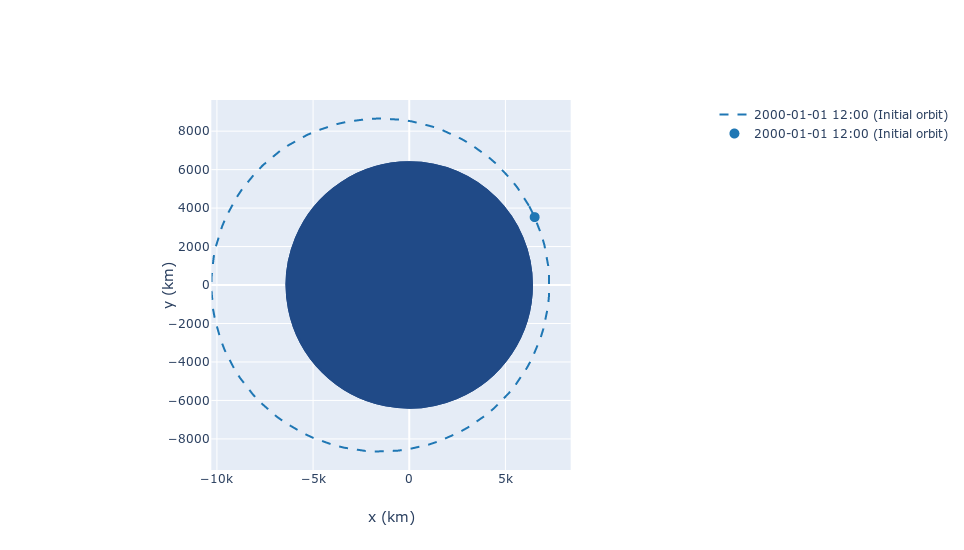

In [4]:
ss.plot(interactive=True, label="Initial orbit")

## First: locate the planets

In [5]:
from astropy.coordinates import solar_system_ephemeris

solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

### Earth

In [6]:
date_launch = time.Time("2011-11-26 15:02", scale="utc")

earth_launch = Orbit.from_body_ephem(Earth, date_launch)
earth_launch

1 x 1 AU x 23.4 deg (ICRS) orbit around Sun (☉) at epoch 2011-11-26 15:03:06.183 (TDB)

In [7]:
earth_launch.r

<Quantity [6.46006434e+07, 1.21424866e+08, 5.26400473e+07] km>

In [8]:
earth_launch.v

<Quantity [-2352414.27027126,  1032013.3380897 ,   447276.92493007] km / d>

### Mars

In [9]:
date_arrival = time.Time("2012-08-06 05:17", scale="utc")

tof = date_arrival - date_launch

mars_arrival = Orbit.from_body_ephem(Mars, date_arrival)
mars_arrival

1 x 2 AU x 24.7 deg (ICRS) orbit around Sun (☉) at epoch 2012-08-06 05:18:07.183 (TDB)

## Second: Compute the trajectory

In [10]:
from poliastro.maneuver import Maneuver

man_lambert = Maneuver.lambert(earth_launch, mars_arrival)

# Get the transfer orbit
ss_trans, _ = earth_launch.apply_maneuver(man_lambert, intermediate=True)
ss_trans

1 x 2 AU x 22.9 deg (HCRS) orbit around Sun (☉) at epoch 2011-11-26 15:03:06.183 (TDB)

In [11]:
from poliastro.twobody.propagation import propagate

tofs = time.TimeDelta(np.linspace(0 * u.h, tof.to(u.h), num=100))

ss_trans_traj = propagate(
    ss_trans,
    tofs,
)
ss_trans_traj

<CartesianRepresentation (x, y, z) in km
    [( 6.46006434e+07,  1.21424866e+08,  52640047.33041224),
     ( 5.80545084e+07,  1.24516693e+08,  53784927.57335334),
     ( 5.13908838e+07,  1.27356560e+08,  54820973.88339874),
     ( 4.46239523e+07,  1.29940462e+08,  55746838.15229787),
     ( 3.77680290e+07,  1.32265292e+08,  56561555.80326675),
     ( 3.08374748e+07,  1.34328847e+08,  57264541.696876  ),
     ( 2.38466107e+07,  1.36129806e+08,  57855582.3980172 ),
     ( 1.68096380e+07,  1.37667715e+08,  58334825.09814053),
     ( 9.74056203e+06,  1.38942953e+08,  58702763.54277354),
     ( 2.65312212e+06,  1.39956697e+08,  58960221.35577004),
     (-4.43927152e+06,  1.40710883e+08,  59108333.17847076),
     (-1.15235945e+07,  1.41208158e+08,  59148524.05437768),
     (-1.85872576e+07,  1.41451834e+08,  59082487.48907179),
     (-2.56181487e+07,  1.41445831e+08,  58912162.60244415),
     (-3.26046674e+07,  1.41194627e+08,  58639710.76770431),
     (-3.95357526e+07,  1.40703204e+08,  582

### ...and it is pure Python!

Trick: **numba**

![Fortran and Python](benchmarks.png)

From my paper Cano Rodríguez, Juan Luis, Helge Eichhorn, and Frazer McLean: poliastro: An Astrodynamics library written in Python with Fortran performance.

## Third: Go to Mars!

In [12]:
from poliastro.plotting import OrbitPlotter3D

plotter = OrbitPlotter3D()

In [13]:
plotter.plot(earth_launch, label="Earth at launch position", color="navy")
plotter.plot(mars_arrival, label="Mars at arrival position", color="red")
plotter.plot_trajectory(ss_trans.sample(max_anomaly=180 * u.deg).cartesian, color="black", label="Transfer orbit")
plotter.set_view(30 * u.deg, 260 * u.deg, distance=3 * u.km)

## Fourth: Make it interactive!!!1!

In [14]:
from ipywidgets import interact, interactive, FloatSlider, VBox
from plotly.graph_objects import FigureWidget

In [15]:
def go_to_mars(tof_h):
    date_arrival = date_launch + tof_h * u.h
    mars_arrival = Orbit.from_body_ephem(Mars, date_arrival)

    man_lambert = Maneuver.lambert(earth_launch, mars_arrival)

    # Get the transfer orbit
    ss_trans, _ = earth_launch.apply_maneuver(man_lambert, intermediate=True)

    tofs = time.TimeDelta(np.linspace(0 * u.h, tof_h * u.h, num=100))
    ss_trans_traj = propagate(
        ss_trans,
        tofs,
    )

    with fig.batch_update():
        # FIXME: Hack to animate the figure seamlessly
        # that however adds more and more invisible traces to the figure 
        for trace in fig.data:
            if "Earth at launch position" not in trace["name"]:
                trace.visible = False

        plotter.plot(mars_arrival, label="Mars at arrival position", color="red")
        plotter.plot_trajectory(ss_trans_traj, color="black", label="Transfer orbit")

In [16]:
fig = FigureWidget()
fig.layout.title = "MSL Mission: from Earth to Mars"

# Plot Earth and set the view in advance
plotter = OrbitPlotter3D(figure=fig)
plotter.plot(earth_launch, label="Earth at launch position", color="navy")
plotter.set_view(30 * u.deg, 260 * u.deg, distance=3 * u.km)

slider = interactive(
    go_to_mars,
    tof_h=FloatSlider(min=5_000, value=6_000, max=12_000, step=250, continuous_update=False),
)

In [17]:
VBox([slider, fig])

## Thank you very much!

### https://docs.poliastro.space
### <hello@juanlu.space>

![Rocket](http://www.esa.int/var/esa/storage/images/esa_multimedia/images/2012/02/liftoff_of_vega_vv014/9659852-3-eng-GB/Liftoff_of_Vega_VV01_large.jpg)